En este script se realizan las predicciones de los modelos entrenados, sobre el conjunto de test.

Primero comenzamos importando las librerías necesarias

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Definimos las rutas necesarias

In [2]:
cwd = os.getcwd()
TEST_DATA_PATH = os.path.join(cwd, "dataset", "test")

# Ruta donde se guardaron los entrenamientos del paso anterior
PROJECT_PATH = os.path.join(cwd, "runs")

# Modelos a evaluar
variants = ['n', 's', 'm']

df = pd.read_csv("full_dataset/ISIC_2019_Training_GroundTruth.csv")
df = df.drop("UNK", axis=1)

target_names = sorted([c for c in df.columns[1:]])
target_names

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

A continuación, se define una función que calcula la predicciones del modelo $y\_pred$, y las devuelve junto con la clasificación real $y\_true$

In [ ]:
def make_predictions(model_path, test_path, class_list):
    print(f"Cargando modelo: {model_path}")
    model = YOLO(model_path)
    
    y_true = []
    y_pred = []
    
    # Iteramos sobre cada carpeta de clase (MEL, NV, etc.)
    for class_name in os.listdir(test_path):
        class_dir = os.path.join(test_path, class_name)
        if not os.path.isdir(class_dir): continue
            
        # Obtenemos el índice numérico de la clase (ej: MEL = 0)
        if class_name in class_list:
            class_idx = class_list.index(class_name)
        else:
            continue
            
        # Listamos imágenes
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        
        if not images: continue

        # Hacemos predicción en lote (más rápido)
        # stream=False devuelve una lista de objetos Result
        results = model.predict(images, verbose=False, imgsz=224)
        
        for res in results:
            # probs.top1 devuelve el índice de la clase con mayor probabilidad
            pred_idx = res.probs.top1
            
            y_true.append(class_idx)
            y_pred.append(pred_idx)
            
    return y_true, y_pred

Para cada modelo, se va a calcular su rendimiento en base a sus predicciones. El rendimiento de cada modelo será guardado para poder ser comparado más adelante.


-------------------Evaluando yolo11n-cls.pt-------------------
Cargando modelo: /home/carlos/3sw/aprendizaje/practicas-aprendizaje/practica4/runs/train_yolo11n-cls.pt/weights/best.pt
Accuracy Global: 0.6625

Reporte de Clasificación:
              precision    recall  f1-score   support

          AK       0.57      0.80      0.67        10
         BCC       0.50      0.30      0.38        10
         BKL       0.64      0.70      0.67        10
          DF       0.70      0.70      0.70        10
         MEL       0.71      0.50      0.59        10
          NV       0.64      0.70      0.67        10
         SCC       0.73      0.80      0.76        10
        VASC       0.80      0.80      0.80        10

    accuracy                           0.66        80
   macro avg       0.66      0.66      0.65        80
weighted avg       0.66      0.66      0.65        80



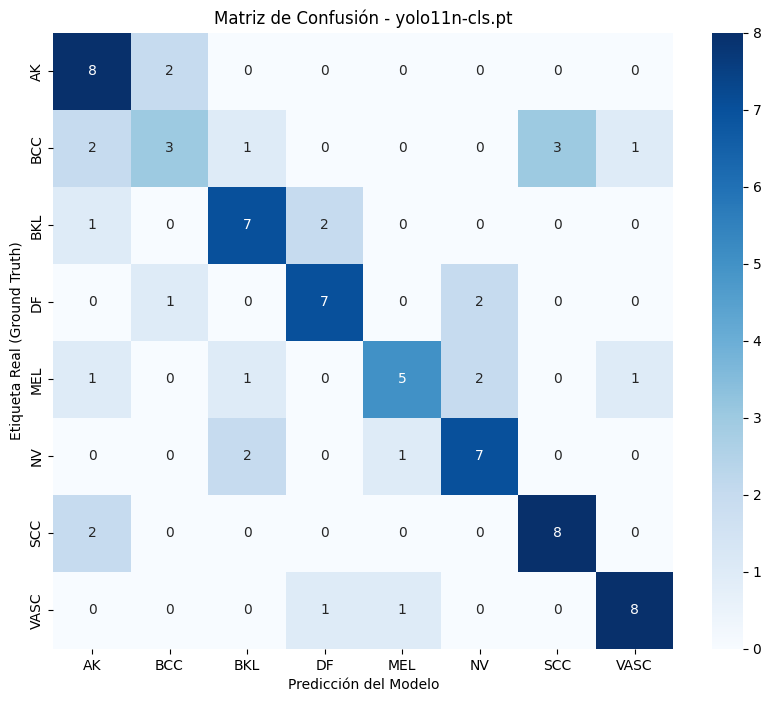


-------------------Evaluando yolo11s-cls.pt-------------------
Cargando modelo: /home/carlos/3sw/aprendizaje/practicas-aprendizaje/practica4/runs/train_yolo11s-cls.pt/weights/best.pt
Accuracy Global: 0.6625

Reporte de Clasificación:
              precision    recall  f1-score   support

          AK       0.50      0.80      0.62        10
         BCC       0.40      0.20      0.27        10
         BKL       1.00      0.50      0.67        10
          DF       0.67      0.80      0.73        10
         MEL       0.60      0.60      0.60        10
          NV       0.80      0.80      0.80        10
         SCC       0.58      0.70      0.64        10
        VASC       0.90      0.90      0.90        10

    accuracy                           0.66        80
   macro avg       0.68      0.66      0.65        80
weighted avg       0.68      0.66      0.65        80



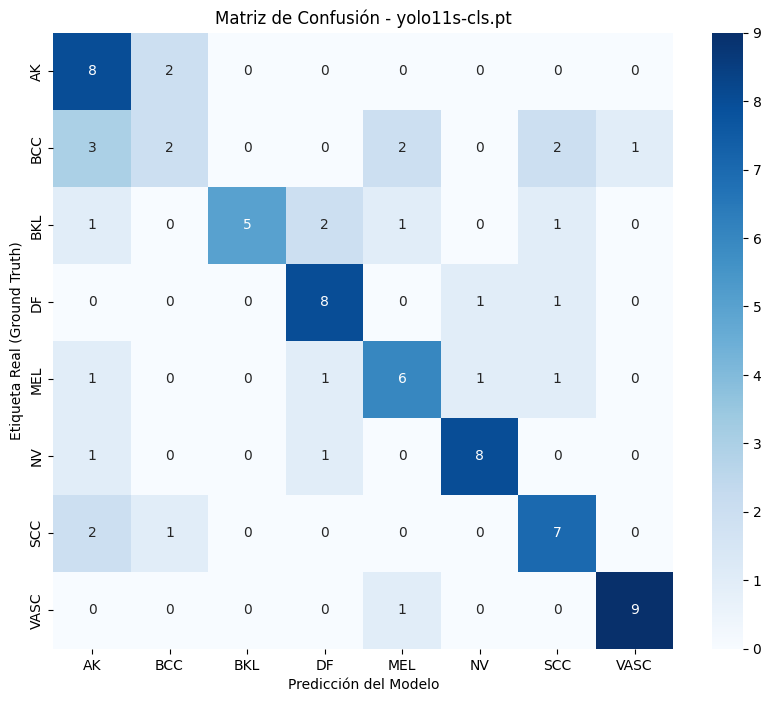


-------------------Evaluando yolo11m-cls.pt-------------------
Cargando modelo: /home/carlos/3sw/aprendizaje/practicas-aprendizaje/practica4/runs/train_yolo11m-cls.pt/weights/best.pt
Accuracy Global: 0.7250

Reporte de Clasificación:
              precision    recall  f1-score   support

          AK       0.78      0.70      0.74        10
         BCC       0.56      0.50      0.53        10
         BKL       0.62      0.50      0.56        10
          DF       0.75      0.90      0.82        10
         MEL       0.80      0.80      0.80        10
          NV       0.69      0.90      0.78        10
         SCC       0.70      0.70      0.70        10
        VASC       0.89      0.80      0.84        10

    accuracy                           0.72        80
   macro avg       0.72      0.72      0.72        80
weighted avg       0.72      0.72      0.72        80



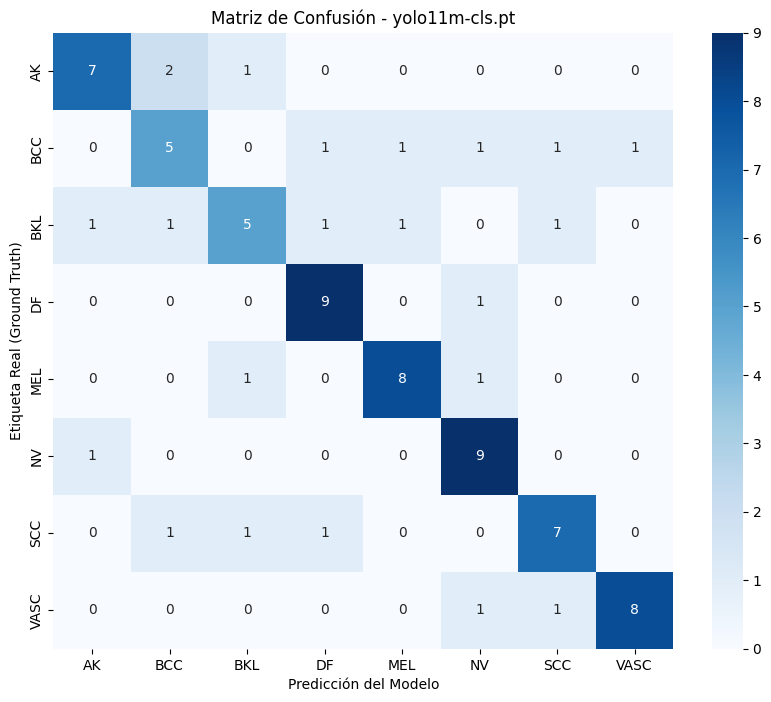


Resumen Final de Accuracy:
Modelo YOLO11N-CLS.PT: 66.25%
Modelo YOLO11S-CLS.PT: 66.25%
Modelo YOLO11M-CLS.PT: 72.50%


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix


metrics = {}

models = ["yolo11n", "yolo11s", "yolo11m"]

for variant in models:
    # Construimos la ruta al archivo best.pt
    model_path = os.path.join(PROJECT_PATH, f'train_{variant}-cls.pt', 'weights', 'best.pt')
    
    if not os.path.exists(model_path):
        print(f"No se encontró el modelo {variant} en {model_path}. Saltando...")
        continue
        
    print(f"\n-------------------Evaluando {variant}-------------------")
    
    # Obtener las predicciones para el conjunto de test
    # con el modelo entrenado
    y_true, y_pred = make_predictions(model_path, TEST_DATA_PATH, target_names)
    
    # Matriz de Confusión
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Etiqueta Real (Ground Truth)')
    plt.title(f'Matriz de Confusión - {variant}')
    plt.show()


    # Calculamos métricas de rendimiento "One vs Rest"
    mlcm = multilabel_confusion_matrix(y_true, y_pred)

    tn = cm[ : , 0, 0]
    tp = cm[ : , 1, 1]
    fn = cm[ : , 1, 0]
    fp = cm[ : , 0, 1]

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = np.mean(tp / (tp + fn))
    recall = sensitivity
    precision = np.mean(tp / (tp + fp))
    fnr = np.mean(fn / (fn + tp))
    fpr = np.mean(fp / (fp + tn))
    specificity = 1 - fpr
    f1 = 2 * precision * recall / (precision + recall)

    metrics[variant] = [accuracy, sensitivity, recall, precision, fnr, fpr, specificity, f1]


